# Ethereum price Prediction using LSTM and ARIMA

# 1. Importing Library

In [96]:
# First we will import the necessary Library 

import os
import pandas as pd
import numpy as np
import math
import datetime as dt

# For Evalution we will use these library

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these library

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from statsmodels.tsa.arima.model import ARIMA


# For PLotting we will use these library

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# 2. Loading Dataset

In [97]:
maindf=pd.read_csv('Data/ETH-USD.csv')

In [98]:
print('Total number of days present in the dataset: ',maindf.shape[0])
print('Total number of fields present in the dataset: ',maindf.shape[1])

Total number of days present in the dataset:  2492
Total number of fields present in the dataset:  7


In [99]:
maindf.shape

(2492, 7)

In [100]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [101]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2487,2024-08-31,2525.859131,2532.389893,2493.705566,2513.393799,2513.393799,6646876013
2488,2024-09-01,2513.424316,2515.467285,2401.889160,2427.902344,2427.902344,11800443265
2489,2024-09-02,2427.973389,2563.085938,2426.095947,2538.187256,2538.187256,12520444224
2490,2024-09-03,2538.160645,2552.802734,2419.875244,2420.603760,2420.603760,11406800197
2491,2024-09-04,2424.616211,2448.003906,2313.500732,2398.707764,2398.707764,16068740096


In [102]:
maindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2492 entries, 0 to 2491
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2492 non-null   object 
 1   Open       2492 non-null   float64
 2   High       2492 non-null   float64
 3   Low        2492 non-null   float64
 4   Close      2492 non-null   float64
 5   Adj Close  2492 non-null   float64
 6   Volume     2492 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 136.4+ KB


In [103]:
maindf.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2492.000000,2492.000000,2492.000000,2492.000000,2492.000000,2.492000e+03
mean,1421.525431,1460.603427,1378.316347,1422.177985,1422.177985,1.241943e+10
std,1206.882663,1238.985663,1170.395195,1206.517780,1206.517780,9.994360e+09
min,84.279694,85.342743,82.829887,84.308296,84.308296,6.217330e+08
25%,247.831642,258.440597,242.204823,247.743229,247.743229,5.260002e+09
50%,1266.439209,1296.919067,1226.479249,1266.369019,1266.369019,1.015476e+10
75%,2226.635864,2280.923950,2150.996033,2228.061218,2228.061218,1.687439e+10
max,4810.071289,4891.704590,4718.039063,4812.087402,4812.087402,8.448291e+10


## Checking for Null Values

In [104]:
print('Null Values:',maindf.isnull().values.sum())

Null Values: 0


In [105]:
print('NA values:',maindf.isnull().values.any())

NA values: False


In [106]:
# Final shape of the dataset after dealing with null values 

maindf.shape

(2492, 7)

# 3. EDA(Exploratory Data Analysis)

In [107]:
# start date and End date of the dataset

sd = maindf.iloc[0, 0]  # Accessing the first row, first column
ed = maindf.iloc[-1, 0]  # Accessing the last row, first column

print('Starting Date:', sd)
print('Ending Date:', ed)



Starting Date: 2017-11-09
Ending Date: 2024-09-04


## Analysis of year 2019

In [108]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2019 = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2020-01-01')]

y_2019.drop(y_2019[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
418,2019-01-01,133.418152,141.397507,132.650711,140.819412
419,2019-01-02,141.519516,156.929138,140.650955,155.047684
420,2019-01-03,155.196045,155.863052,147.198364,149.135010
421,2019-01-04,148.912888,156.878983,147.907104,154.581940
422,2019-01-05,154.337418,160.824890,154.337418,155.638596
...,...,...,...,...,...
778,2019-12-27,126.368797,128.097565,124.820808,127.214607
779,2019-12-28,127.213013,130.258163,126.899696,128.322708
780,2019-12-29,128.266876,136.811203,127.997658,134.757980
781,2019-12-30,134.796524,136.757355,131.545563,132.633484


In [109]:
monthwise= y_2019.groupby(y_2019['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,129.056986,128.174619
February,126.112229,127.220948
March,137.202461,137.327039
April,164.899545,165.603831
May,216.730067,220.185853
June,274.005168,274.758299
July,250.595550,248.289667
August,201.309426,199.817084
September,185.712475,185.992064


In [110]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [111]:
y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2019.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2019.groupby(y_2019['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [112]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])
dates_array = np.array(y_2019['Date'], dtype='datetime64')
fig = px.line(y_2019, x=dates_array, y=[y_2019['Open'], y_2019['Close'], 
                                          y_2019['High'], y_2019['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Analysis of Year 2020

In [113]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2020 = maindf.loc[(maindf['Date'] >= '2020-01-01')
                     & (maindf['Date'] < '2021-01-01')]

y_2020.drop(y_2020[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
783,2020-01-01,129.630661,132.835358,129.198288,130.802002
784,2020-01-02,130.820038,130.820038,126.954910,127.410179
785,2020-01-03,127.411263,134.554016,126.490021,134.171707
786,2020-01-04,134.168518,136.052719,133.040558,135.069366
787,2020-01-05,135.072098,139.410202,135.045624,136.276779
...,...,...,...,...,...
1144,2020-12-27,635.887146,711.393555,628.334961,682.642334
1145,2020-12-28,683.205811,745.877747,683.205811,730.397339
1146,2020-12-29,730.358704,737.952881,692.149414,731.520142
1147,2020-12-30,731.472839,754.303223,720.988892,751.618958


In [114]:
monthwise= y_2020.groupby(y_2020['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,155.320137,156.972718
February,237.377253,238.756287
March,163.235093,160.376243
April,169.488213,171.946989
May,207.346755,208.125855
June,236.268403,236.159229
July,255.554494,259.405542
August,399.326147,402.153482
September,370.883198,368.373035


In [115]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [116]:
y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2020.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2020.groupby(y_2020['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [117]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_2020, x=y_2020.Date, y=[y_2020['Open'], y_2020['Close'], 
                                          y_2020['High'], y_2020['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Analysis of Year 2021

In [118]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2021 = maindf.loc[(maindf['Date'] >= '2021-01-01')
                     & (maindf['Date'] < '2022-01-01')]

y_2021.drop(y_2021[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1149,2021-01-01,737.708374,749.201843,719.792236,730.367554
1150,2021-01-02,730.402649,786.798462,718.109497,774.534973
1151,2021-01-03,774.511841,1006.565002,771.561646,975.507690
1152,2021-01-04,977.058838,1153.189209,912.305359,1040.233032
1153,2021-01-05,1041.498779,1129.371460,986.811279,1100.006104
...,...,...,...,...,...
1509,2021-12-27,4064.746338,4126.001465,4033.492432,4037.547607
1510,2021-12-28,4037.538086,4037.538086,3769.280029,3800.893066
1511,2021-12-29,3797.436279,3827.981934,3612.795898,3628.531738
1512,2021-12-30,3632.219727,3767.559814,3595.204834,3713.852051


In [119]:
monthwise= y_2021.groupby(y_2021['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,1184.997553,1202.502802
February,1696.234375,1699.808921
March,1720.526655,1736.862222
April,2269.130294,2297.672754
May,3142.513688,3140.730760
June,2349.590800,2335.792391
July,2122.466194,2131.080362
August,3069.708630,3098.384939
September,3349.545020,3337.052686


In [120]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [121]:
y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2021.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2021.groupby(y_2021['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [122]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_2021, x=y_2021.Date, y=[y_2021['Open'], y_2021['Close'], 
                                          y_2021['High'], y_2021['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Analysis of Year 2022

In [123]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2022 = maindf.loc[(maindf['Date'] >= '2022-01-01')
                     & (maindf['Date'] < '2023-01-01')]

y_2022.drop(y_2022[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1514,2022-01-01,3683.047119,3769.917969,3682.286621,3769.697021
1515,2022-01-02,3769.298340,3836.161865,3727.357422,3829.564941
1516,2022-01-03,3829.535645,3836.198730,3698.047607,3761.380371
1517,2022-01-04,3761.361572,3876.785156,3723.349854,3794.056641
1518,2022-01-05,3794.269043,3842.059814,3456.745361,3550.386963
...,...,...,...,...,...
1874,2022-12-27,1226.987061,1230.418091,1205.895630,1212.791626
1875,2022-12-28,1212.736572,1213.128906,1185.702148,1189.986084
1876,2022-12-29,1190.010132,1204.141602,1188.360229,1201.595337
1877,2022-12-30,1201.569580,1202.034668,1187.462524,1199.232788


In [124]:
monthwise= y_2022.groupby(y_2022['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,3086.863077,3054.655100
February,2859.761945,2868.178973
March,2864.621740,2876.342340
April,3115.222518,3096.986271
May,2213.557712,2187.318915
June,1411.869230,1382.772276
July,1339.623811,1359.407778
August,1703.347814,1699.230370
September,1491.504883,1484.229456


In [125]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [126]:
y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2022.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2022.groupby(y_2022['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [127]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_2022, x=y_2022.Date, y=[y_2022['Open'], y_2022['Close'], 
                                          y_2022['High'], y_2022['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Analysis of Year 2023

In [128]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2023 = maindf.loc[(maindf['Date'] >= '2023-01-01')
                     & (maindf['Date'] < '2024-01-01')]

y_2023.drop(y_2023[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
1879,2023-01-01,1196.713623,1203.475342,1192.885376,1200.964844
1880,2023-01-02,1201.103271,1219.860596,1195.214966,1214.656616
1881,2023-01-03,1214.744019,1219.095337,1207.491577,1214.778809
1882,2023-01-04,1214.718628,1264.807495,1213.168823,1256.526611
1883,2023-01-05,1256.484619,1258.571533,1245.173096,1250.438599
...,...,...,...,...,...
2239,2023-12-27,2231.393066,2392.608643,2215.140381,2378.739990
2240,2023-12-28,2380.200684,2445.017578,2338.703857,2347.566162
2241,2023-12-29,2346.843750,2386.004639,2262.975830,2300.690674
2242,2023-12-30,2300.399658,2322.021484,2270.011963,2292.065430


In [129]:
monthwise= y_2023.groupby(y_2023['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,1454.913763,1466.950026
February,1623.919765,1624.605630
March,1668.488836,1675.357851
April,1915.151611,1916.934652
May,1845.306196,1845.626378
June,1816.607914,1818.705579
July,1895.858863,1893.345290
August,1763.744975,1756.978157
September,1620.422725,1621.299198


In [130]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [131]:
y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2023.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2023.groupby(y_2023['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [132]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_2023, x=y_2023.Date, y=[y_2023['Open'], y_2023['Close'], 
                                          y_2023['High'], y_2023['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Analysis of Year 2024

In [133]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_2024 = maindf.loc[(maindf['Date'] >= '2024-01-01')
                     & (maindf['Date'] < '2024-09-01')]

y_2024.drop(y_2024[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
2244,2024-01-01,2282.870361,2352.327881,2267.018066,2352.327881
2245,2024-01-02,2352.593506,2431.212402,2348.892334,2355.836426
2246,2024-01-03,2355.981445,2385.117676,2113.925293,2210.761963
2247,2024-01-04,2210.529053,2294.608154,2204.865723,2269.038086
2248,2024-01-05,2269.409424,2276.764648,2209.537109,2268.647217
...,...,...,...,...,...
2483,2024-08-27,2681.622803,2700.152832,2401.175049,2458.726563
2484,2024-08-28,2458.904785,2553.820068,2422.293701,2528.415527
2485,2024-08-29,2528.362305,2595.977051,2507.502441,2528.792725
2486,2024-08-30,2528.732178,2539.915283,2432.834473,2525.822021


In [134]:
monthwise= y_2024.groupby(y_2024['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,2375.056200,2374.858359
February,2710.419644,2746.785097
March,3618.246062,3627.963316
April,3267.710766,3246.560026
May,3282.887530,3307.055908
June,3577.799211,3566.957788
July,3277.320675,3270.763601
August,2665.168315,2642.017775
September,NaN,NaN


In [135]:
fig = go.Figure()

fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Open'],
    name='ETH Open Price',
    marker_color='crimson'
))
fig.add_trace(go.Bar(
    x=monthwise.index,
    y=monthwise['Close'],
    name='ETH Close Price',
    marker_color='lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=-45, 
                  title='Monthwise comparision between ETH open and close price')
fig.show()

In [136]:
y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthwise_high = y_2024.groupby(maindf['Date'].dt.strftime('%B'))['High'].max()
monthwise_high = monthwise_high.reindex(new_order, axis=0)

monthwise_low = y_2024.groupby(y_2024['Date'].dt.strftime('%B'))['Low'].min()
monthwise_low = monthwise_low.reindex(new_order, axis=0)

fig = go.Figure()
fig.add_trace(go.Bar(
    x=monthwise_high.index,
    y=monthwise_high,
    name='ETH high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthwise_low.index,
    y=monthwise_low,
    name='ETH low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(barmode='group', 
                  title=' Monthwise High and Low ETH price')
fig.show()

In [137]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_2024, x=y_2024.Date, y=[y_2024['Open'], y_2024['Close'], 
                                          y_2024['High'], y_2024['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

## Overall Analysis from 2019-2024

In [138]:
maindf['Date'] = pd.to_datetime(maindf['Date'], format='%Y-%m-%d')

y_overall = maindf.loc[(maindf['Date'] >= '2019-01-01')
                     & (maindf['Date'] < '2024-09-01')]

y_overall.drop(y_overall[['Adj Close','Volume']],axis=1)

,Date,Open,High,Low,Close
418,2019-01-01,133.418152,141.397507,132.650711,140.819412
419,2019-01-02,141.519516,156.929138,140.650955,155.047684
420,2019-01-03,155.196045,155.863052,147.198364,149.135010
421,2019-01-04,148.912888,156.878983,147.907104,154.581940
422,2019-01-05,154.337418,160.824890,154.337418,155.638596
...,...,...,...,...,...
2483,2024-08-27,2681.622803,2700.152832,2401.175049,2458.726563
2484,2024-08-28,2458.904785,2553.820068,2422.293701,2528.415527
2485,2024-08-29,2528.362305,2595.977051,2507.502441,2528.792725
2486,2024-08-30,2528.732178,2539.915283,2432.834473,2525.822021


In [139]:
monthwise= y_overall.groupby(y_overall['Date'].dt.strftime('%B'))[['Open','Close']].mean()
new_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
             'September', 'October', 'November', 'December']
monthwise = monthwise.reindex(new_order, axis=0)
monthwise

,Open,Close
Date,,
January,1397.701286,1397.352271
February,1541.499428,1550.208855
March,1695.386808,1702.371502
April,1816.933825,1815.950754
May,1818.056991,1818.173945
June,1611.023454,1602.524260
July,1523.569931,1527.048707
August,1633.767551,1633.096968
September,1403.613660,1399.389288


In [140]:
names = cycle(['ETH Open Price','ETH Close Price','ETH High Price','ETH Low Price'])

fig = px.line(y_overall, x=y_overall.Date, y=[y_overall['Open'], y_overall['Close'], 
                                          y_overall['High'], y_overall['Low']],
             labels={'Date': 'Date','value':'ETH value'})
fig.update_layout(title_text='ETH analysis chart', font_size=15, font_color='black',legend_title_text='ETH Parameters')
fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

fig.show()

# 4. LSTM Model

## Model Building

### Preparing Data for Training and Testing

In [141]:
# Take all the Close Price 
closedf = maindf[['Date','Close']]
print("Shape of close dataframe:", closedf.shape)

Shape of close dataframe: (2492, 2)


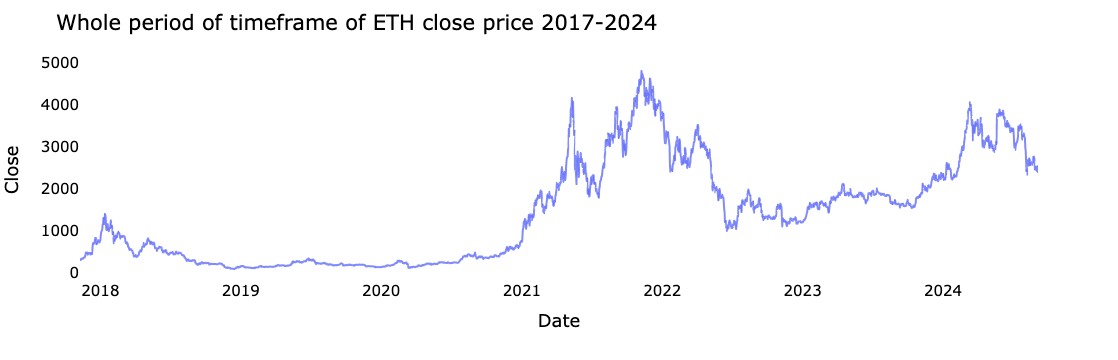

In [142]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close ETH'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of timeframe of ETH close price 2017-2024', plot_bgcolor='white', 
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Take data of 1 Year

In [143]:
closedf = closedf[closedf['Date'] > '2023-09-04']
close_ETH = closedf.copy()
print("Total data for prediction: ",closedf.shape[0])

Total data for prediction:  366


In [144]:
closedf

,Date,Close
2126,2023-09-05,1633.629395
2127,2023-09-06,1632.252319
2128,2023-09-07,1647.598267
2129,2023-09-08,1636.137817
2130,2023-09-09,1635.162354
...,...,...
2487,2024-08-31,2513.393799
2488,2024-09-01,2427.902344
2489,2024-09-02,2538.187256
2490,2024-09-03,2420.603760


In [145]:
fig = px.line(closedf, x=closedf.Date, y=closedf.Close,labels={'date':'Date','close':'Close ETH'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict ETH close price', 
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Normalizing Data

In [146]:
# deleting date column and normalizing using MinMax Scaler

del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(366, 1)


### Slicing data into Training set and Testing set

In [147]:
# The training set as 60% and 40% testing set

training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (219, 1)
test_data:  (147, 1)


### Now we Transform the Close price based on Time-series-analysis forecasting requirement , Here we will take 15   

In [148]:
# convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [149]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (203, 15)
y_train:  (203,)
X_test:  (131, 15)
y_test (131,)


In [150]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (203, 15, 1)
X_test:  (131, 15, 1)


### LSTM Model Building

In [151]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [152]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.2002 - val_loss: 0.4352
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1967 - val_loss: 0.3651
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1621 - val_loss: 0.2978
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1294 - val_loss: 0.2344
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0956 - val_loss: 0.1731
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0631 - val_loss: 0.1159
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0534 - val_loss: 0.0627
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.0236
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0113
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0109
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0082


In [154]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,475 (5.77 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 984 (3.85 KB)

## Model Evaluation

- ### Plotting Loss vs Validation loss

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
### prediction and performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

- ### Evaluation

In [ ]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

- ### Evaluation metrices RMSE, MSE and MAE

In [ ]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

- ### Variance Regression Score

In [ ]:
#High Score: If the score is close to 1, it means guesses are very good at predicting.
#Low Score: If the score is close to 0, it means the guesses are not very good.

print("Train data explained variance regression score:", 
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", 
      explained_variance_score(original_ytest, test_predict))

- ### R square score for regression

In [ ]:
#Score of 1: Perfect! Your guesses match the actual values exactly.
#Score of 0: Your guesses are no better than just guessing the average value.
#Negative Score: Worse than guessing the average value, meaning your guesses are pretty bad.

print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

- ### Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)

In [ ]:
# Lower MGD and MPD values are better, indicating that your predictions are closer to the actual values

print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

- ### Comparision of original ETH close price and predicted close price

In [ ]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_ETH['Date'],
                       'original_close': close_ETH['Close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'ETH price','date': 'Date'})
fig.update_layout(title_text='Comparision between original close price vs predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

## Model Prediction

### Predicting next 30 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

### Plotting last 15 days of dataset and next predicted 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'ETH price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



### Plotting entire Closing ETH Price with next 30 days period of prediction

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'ETH price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing ETH price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='ETH')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

The End of ETH Price Prediction using LSTM.

# 5. ARIMA Model

## Model Building

### Preparing Data for Training and Testing

In [ ]:
closedf = maindf[['Date', 'Close']]
print("Shape of close dataframe:", closedf.shape)

### Take data of 5 Year

In [ ]:
closedf = closedf[closedf['Date'] > '2019-09-04']
close_ETH = closedf.copy()
print("Total data for prediction: ", closedf.shape[0])
fig = px.line(closedf, x=closedf.Date, y=closedf.Close, labels={'date': 'Date', 'close': 'Close ETH'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict ETH close price',
                  plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

### Ensure 'Date' is already set as index

In [ ]:
closedf.set_index('Date', inplace=True)

### Splitting data into Training set and Testing set (60% Training, 40% Testing)

In [ ]:
training_size = int(len(closedf) * 0.60)
train_data, test_data = closedf[:training_size], closedf[training_size:]

print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

In [ ]:
model_predictions = []
num_of_test_obser = len(test_data)
num_of_test_obser

In [ ]:
# Convert train_data and test_data to list for iterative updates
training_data = train_data.values.flatten().tolist()  # Convert to a flat list
testing_data = test_data.values.flatten().tolist()    # Convert to a flat list

### Model Building

In [ ]:
p, d, q = 5, 1, 0  
# Forecast each test observation
for i in range(num_of_test_obser):
    model = ARIMA(training_data, order=(p, d, q))  # Parameters can be adjusted
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = list(output)[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)  

In [ ]:
yhat

In [ ]:
print(model_fit.summary())

## Model Evaluation

### Calculating loss and MSE for each ARIMA prediction step

In [ ]:
arima_losses = []

for i in range(num_of_test_obser):
    # Calculate the squared error for each prediction step
    error = (testing_data[i] - model_predictions[i]) ** 2
    arima_losses.append(error)

# Calculate cumulative loss over time
cumulative_arima_loss = [sum(arima_losses[:i+1]) / (i+1) for i in range(len(arima_losses))]

# Plotting ARIMA loss
plt.plot(range(len(cumulative_arima_loss)), cumulative_arima_loss, 'g', label='ARIMA Cumulative Loss')
plt.title('Cumulative Loss for ARIMA Model')
plt.xlabel('Prediction Step')
plt.ylabel('Cumulative Mean Squared Error')
plt.legend(loc='best')
plt.show()

### Turn back to DataFrame for evaluation

In [ ]:
model_predictions = np.array(model_predictions)
testing_data = np.array(testing_data)

### Evaluation Metrics: RMSE, MSE, and MAE for ARIMA predictions

In [ ]:
print("ARIMA Model Evaluation Metrics:")
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(testing_data, model_predictions)))
print("Test data MSE: ", mean_squared_error(testing_data, model_predictions))
print("Test data MAE: ", mean_absolute_error(testing_data, model_predictions))


In [ ]:
# Variance Regression Score
print("Test data explained variance regression score:", explained_variance_score(testing_data, model_predictions))


In [ ]:
# R2 score for regression
print("Test data R2 score:", r2_score(testing_data, model_predictions))

In [ ]:
# Regression Loss Mean Gamma deviance regression loss (MGD) and Mean Poisson deviance regression loss (MPD)
print("Test data MGD: ", mean_gamma_deviance(testing_data, model_predictions))
print("Test data MPD: ", mean_poisson_deviance(testing_data, model_predictions))


In [ ]:
# Initialize an empty array of NaN values for plotting ARIMA results
arimaPredictPlot = np.empty_like(close_ETH['Close'])
arimaPredictPlot[:] = np.nan

# Check the length of training data
start_index = len(close_ETH) - len(model_predictions)

# Ensure the index range matches the length of model_predictions
if start_index < len(arimaPredictPlot):
    arimaPredictPlot[start_index:start_index + len(model_predictions)] = model_predictions
else:
    print("Error: Starting index is out of bounds.")

names = cycle(['Original close price', 'ARIMA Test predicted close price'])

# Prepare DataFrame for plotting original and predicted close prices
plotdf_arima = pd.DataFrame({
    'date': close_ETH['Date'],
    'original_close': close_ETH['Close'],
    'arima_test_predicted_close': arimaPredictPlot.tolist()
})

# Plotting original vs. ARIMA predicted close prices
fig = px.line(
    plotdf_arima, 
    x=plotdf_arima['date'],
    y=[plotdf_arima['original_close'], plotdf_arima['arima_test_predicted_close']],
    labels={'value': 'ETH price', 'date': 'Date'}
)

fig.update_layout(
    title_text='Comparison between Original Close Price vs ARIMA Predicted Close Price',
    plot_bgcolor='white', 
    font_size=15, 
    font_color='black', 
    legend_title_text='Close Price'
)

fig.for_each_trace(lambda t: t.update(name=next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


## Model Prediction

### Predicting next 30 days

In [ ]:
# Assume `model_fit` is the already trained ARIMA model on `training_data`
# Initialize temporary input with the last time_step observations from testing data
temp_input = testing_data[-time_step:].tolist()

# List to store ARIMA predictions for the next 30 days
arima_predictions = []

# Number of future days to predict
pred_days = 30

# Use the already trained model for prediction
for i in range(pred_days):
    # Forecast the next value using the already trained model
    yhat = model_fit.forecast(steps=1)[0]  # Forecast the next step

    # Append the forecasted value to the predictions list
    arima_predictions.append(yhat)

    # Update temp_input by adding the new prediction
    temp_input.append(yhat)

    # Maintain the last `time_step` values for future forecasting
    temp_input = temp_input[1:]

    # If necessary, update the model with the latest data point
    model_fit = model_fit.append([yhat])  # Update the model with the latest forecasted value if needed

# Display the number of predicted values
print("Output of predicted next days:", len(arima_predictions))

# Optional: Print the predicted values
print("ARIMA Predictions for the next 30 days:", arima_predictions)


### Plotting last 15 days of dataset and next predicted 30 days

In [ ]:
last_days = np.arange(1, time_step + 1)  # Last observed days range
day_pred = np.arange(time_step + 1, time_step + pred_days + 1)  # Future predicted days range


print(last_days)
print(day_pred)

In [ ]:
# Prepare placeholders with NaN values for plotting
temp_mat = np.empty((len(last_days) + len(day_pred), 1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1, -1).tolist()[0]

# Create copies for last observed values and predicted values
last_original_days_value = temp_mat.copy()
next_predicted_days_value = temp_mat.copy()

# Assign the last observed close prices (e.g., last 15 days)
last_original_days_value[0:time_step] = closedf['Close'][len(closedf) - time_step:].tolist()

# Assign the ARIMA predicted values (e.g., next 30 days)
next_predicted_days_value[time_step:] = arima_predictions[:pred_days]

# Adjust lists to the same length by filling the missing values as needed
min_length = min(len(last_original_days_value), len(next_predicted_days_value))
last_original_days_value = last_original_days_value[:min_length]
next_predicted_days_value = next_predicted_days_value[:min_length]

# Create a DataFrame for plotting
new_pred_plot = pd.DataFrame({
    'last_original_days_value': last_original_days_value,
    'next_predicted_days_value': next_predicted_days_value
})

# Cycle names for better labeling in plots
names = cycle(['Last observed days close price', 'Predicted next 30 days close price'])

# Plot comparison between the last observed days and the predicted future days
fig = px.line(new_pred_plot, x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                       new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Close price', 'index': 'Timestamp'})
fig.update_layout(title_text='Comparison: Last observed days vs. next 30 predicted days',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')

# Update trace names with the cycle defined above
fig.for_each_trace(lambda t: t.update(name=next(names)))

# Disable gridlines for a cleaner look
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


### Plotting entire Closing ETH Price with next 30 days period of prediction

In [ ]:
# Combine historical data with predictions for a complete plot
combined_data = closedf['Close'].tolist() + arima_predictions[:pred_days]

# Define names for the entire series
names = cycle(['Close price'])

# Plot the entire series including the predictions
fig = px.line(combined_data, labels={'value': 'Close price', 'index': 'Timestamp'})
fig.update_layout(title_text='Full closing price with ARIMA prediction',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Price')

# Update trace name for clear identification
fig.for_each_trace(lambda t: t.update(name=next(names)))

# Disable gridlines for a cleaner look
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

The End of ETH Price Prediction using ARIMA.